# SMU 7331 Data Mining Project 3
##### Authors: Shon Mohsin, Heber Nielsen, Jose Torres, Lokesh Maganti

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as pltw
from pandas.plotting import scatter_matrix, parallel_coordinates
from sklearn.metrics import pairwise
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN
from sklearn.neighbors import kneighbors_graph
from sklearn.mixture import GaussianMixture

import urllib
import re

## Business Understanding: 
#### Requirements: Describe the purpose of the data set you selected (i.e., why was this data collected in the first place?). How will you measure the effectiveness of a good algorithm? Why does your chosen validation method make sense for this specific dataset and the stakeholders needs?

In [2]:
# Data Import from Github
url = 'https://raw.githubusercontent.com/hebernielsen/DS7331_Project3/master/allUsers.lcl.csv' 
df=pd.read_csv(url)
df.head()

,Class,User,X0,Y0,Z0,X1,Y1,Z1,X2,Y2,...,Z8,X9,Y9,Z9,X10,Y10,Z10,X11,Y11,Z11
0,0,0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0,0,0,0,0,0,0,0,0,0
1,1,0,54.263880,71.466776,-64.807709,76.895635,42.462500,-72.780545,36.621229,81.680557,...,?,?,?,?,?,?,?,?,?,?
2,1,0,56.527558,72.266609,-61.935252,39.135978,82.538530,-49.596509,79.223743,43.254091,...,?,?,?,?,?,?,?,?,?,?
3,1,0,55.849928,72.469064,-62.562788,37.988804,82.631347,-50.606259,78.451526,43.567403,...,?,?,?,?,?,?,?,?,?,?
4,1,0,55.329647,71.707275,-63.688956,36.561863,81.868749,-52.752784,86.320630,68.214645,...,?,?,?,?,?,?,?,?,?,?


Our selected dataset captures hand gestures using Vicon Motion Capture System using a glove with markers, described in detail in the Data Understanding section. The dataset is comprised of 12 users making 5 pre-defined hand gestures below:

1. Fist
2. Stop
3. Point with one finger
4. Point with two fingers
5. Grab

The business problem is to perform cluster analysis on the 5 gestures, regardless of user, to see if discernable patterns can be used to identify the 5 gestures from a combined set where the 12 users are de-identified. 

Our assumption is that the gestures should be similar regardless of the individual user making the gesture. 

## Data Understanding 1:
#### Requirements: Visualize the any important attributes appropriately. Important: Provide an interpretation for any charts or graphs.

Our selected dataset captures hand gestures using Vicon Motion Capture System. 

1.The Dataset is the collection,features and organization of motion capture datasets for hand posture and gesture recognition.

2.The purpose of this dataset is to provide the range of motion for each part of the hand/glove to which a marker is attached.

3.Glove constructed to serve as the source of data for all algorithms analysis and development.

4.A glove with fifteen markers attached is used as the source of data for posture and gesture recognition, both for the generation of datasets and for the practical evaluation of developed algorithms.

5.The glove used to capture data along with a sample from each class of posture projected onto the local XY plane. The classes are fist (1), stop (2),point with one finger (3), point with two fingers (4), and grab (5).

6.The data described here is already partially preprocessed in the following manner. The data was transformed and pruned in the same manner as the La-beled Marker Dataset. Any record that could not be transformed or contained fewer than three markers was removed.

7.This dataset may be used for a variety of tasks, the most obvious of which is posture recognition via classication. One may also attempt user identication.Alternatively, one may perform clustering (constrained or unconstrained) to discover marker distributions either as an attempt to predict marker identities or obtain statistical descriptions/visualizations of the postures.

8.Since the pattern is not always visible and has noisy or even incorrect ob-servations, alter should be used to smooth the measurements of the labeled markers.

### Attribute Information:

Data is provided as a CSV file. A header provides the name of each attribute. An initial dummy record composed entirely of 0s should be ignored. A question mark '?' is used to indicate a missing value. A record corresponds to a single instant or frame as recorded by the camera system.

'Class' - Integer. The class ID of the given record. Ranges from 1 to 5 with 1=Fist(with thumb out), 2=Stop(hand flat), 3=Point1(point with pointer finger), 4=Point2(point with pointer and middle fingers), 5=Grab(fingers curled as if to grab). 'User' - Integer. The ID of the user that contributed the record. No meaning other than as an identifier.

Xi - Real. The x-coordinate of the i-th unlabeled marker position. 'i' ranges from 0 to 11.

'Yi' - Real. The y-coordinate of the i-th unlabeled marker position. 'i' ranges from 0 to 11.

'Zi' - Real. The z-coordinate of the i-th unlabeled marker position. 'i' ranges from 0 to 11.
Each record is a set. The i-th marker of a given record does not necessarily
correspond to the i-th marker of a dierent record. One may randomly permute
7
the visible (i.e. not missing) markers of a given record without changing the set
that the record represents. For the sake of convenience, all visible markers of
a given record are given a lower index than any missing marker. A class is not
guaranteed to have even a single record with all markers visible.

### Missing Data and Normalization:

The following preprocessing steps were made to this data:

1) Remove Class 0, which is not a valid Class.
2) Replace '?' values with np.NaN

In [3]:
dropped_indices = df.query('Class==0').index
df = (df
      .drop(labels=dropped_indices, axis=0, errors='ignore')
      .replace(to_replace='?', value=np.nan))

#set data types
df = (pd.concat([df.iloc[:,:2].astype(str), 
                df.iloc[:,2:].astype(np.float64)], axis=1)
      .melt(id_vars=['User', 'Class'])
      .dropna())

In [4]:
df['variable'] = (df['variable'].str
                  .replace('X.*', 'X', regex=True)
                  .replace('Y.*', 'Y', regex=True)
                  .replace('Z.*', 'Z', regex=True))
df['Class'] = df['Class'].map({'1': 'fist', '2': 'stop', 
                               '3': 'pointer', '4': 'pointer_middle', '5': 'grab'})

In [5]:
df.head()

,User,Class,variable,value
0,0,fist,X,54.263880
1,0,fist,X,56.527558
2,0,fist,X,55.849928
3,0,fist,X,55.329647
4,0,fist,X,55.142401


In [6]:
df_adjacent_coords = pd.DataFrame({'User': df.query('variable==\'X\'').reset_index()['User'], 
                                   'Class': df.query('variable==\'X\'').reset_index()['Class'], 
                                   'X': df.query('variable==\'X\'').reset_index()['value'], 
                                   'Y': df.query('variable==\'Y\'').reset_index()['value'],
                                   'Z': df.query('variable==\'Z\'').reset_index()['value']})
df_adjacent_coords.head()

,User,Class,X,Y,Z
0,0,fist,54.263880,71.466776,-64.807709
1,0,fist,56.527558,72.266609,-61.935252
2,0,fist,55.849928,72.469064,-62.562788
3,0,fist,55.329647,71.707275,-63.688956
4,0,fist,55.142401,71.435607,-64.177303


In [7]:
#pivot not correct
#X, Y, Z needed
#concatenate: X rows, Y rows, Z rows (same shape)


The cell below shifts all sensors according to the average position of the 4 sensors on the back of the hand.

Here is an outline of the normalization process in some more detail:

First, we get the mean position of all 4 origin sensors.  The x-value is stored in `mainsensor_x_mean`.  The y-value in `mainsensor_y_mean`, and the z-value in `mainsensor_z_mean`.  

Repeat for each gesture and user:
+ Loop through all coordinates, shifting x-coordinate by `mainsensor_x_mean`, y-coordinates by `mainsensor_y_mean`, and z_coordinates by `mainsensor_z_mean`.

## Data Understanding 2:
#### Requirements: Choose and explain your evaluation metrics that you will use (i.e., accuracy, precision, recall, F-measure, or any metric we have discussed). Why are the measure(s) appropriate for analyzing the results of your modeling? Give a detailed explanation backing up any assertions.

In [23]:
y = df_adjacent_coords['Class']
X = (df_adjacent_coords
     .query('Class==\'fist\'')
     .loc[:,['X','Y','Z']]
     .values)

In [24]:
model = DBSCAN(eps=1, min_samples=250).fit(X)

In [10]:
#accuracy
#precision
#recall
#F-score

#n_clusters = 2
#model = KMeans(init='k-means++', n_clusters=n_clusters, n_init=1).fit(data)
# model = AgglomerativeClustering(linkage='ward', n_clusters=n_clusters).fit(data)


labels = model.labels_
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)

print('Estimated number of clusters: %d' % n_clusters_)
# print("Homogeneity: %0.3f" % metrics.homogeneity_score(labels_true, labels))
# print("Completeness: %0.3f" % metrics.completeness_score(labels_true, labels))
# print("V-measure: %0.3f" % metrics.v_measure_score(labels_true, labels))
# print("Adjusted Rand Index: %0.3f"
#       % metrics.adjusted_rand_score(labels_true, labels))
# print("Adjusted Mutual Information: %0.3f"
#       % metrics.adjusted_mutual_info_score(labels_true, labels))
# print("Silhouette Coefficient: %0.3f"
#       % metrics.silhouette_score(data, labels))

# silhouette_per_sample = metrics.silhouette_samples(data,labels)

# # get the middle of each cluster
# centroids = []
# for lab in range(0,n_clusters_):
#     centroids.append( [np.mean(data[np.where(labels==lab),0]), np.mean(data[np.where(labels==lab),1])] )
# centroids = np.array(centroids)

# plt.figure()
# plt.scatter(data[:, 0], data[:, 1], c=labels,
#                     cmap=plt.cm.spectral, s=5, linewidths=0)

# if len(centroids)>0:
#     plt.scatter(centroids[:, 0], centroids[:, 1],
#                 marker='+', s=200, linewidths=3, color='k', zorder=10)  # plot the centroids
# plt.title('Estimated number of clusters: %d' % n_clusters_)

# plt.figure()
# plt.scatter(data[:, 0], data[:, 1], c=silhouette_per_sample,
#                 cmap=plt.cm.gray, s=5, linewidths=0)
# plt.title('Clusters with silhouette coefficient coloring')
# plt.show()

Estimated number of clusters: 23


In [11]:
pd.Series(labels).value_counts()

-1     71759
 15     1590
 16     1526
 17     1478
 18     1424
 2      1234
 11     1228
 13     1001
 20      945
 12      933
 19      891
 0       870
 21      818
 10      645
 6       580
 7       547
 1       488
 14      462
 9       432
 3       393
 5       371
 22      353
 4       337
 8       310
dtype: int64

In [12]:
pd.Series(labels).value_counts().plot(kind='bar')

In [26]:
#clustering code
from sklearn.model_selection import cross_val_score

#import, clean, and preprocess data before defining X1
clf = KMeans(n_clusters=5, init='k-means++',random_state=1)
clf.fit(X)
fitted_labels = clf.labels_ # the labels from kmeans clustering
#acc = cross_val_score(clf,X,y=y)

#print ("Average accuracy (with kmeans for class/fare)= ", acc.mean()*100, "+-", acc.std()*100)

# number of clusters with silhouette analysis on KMeans clustering

Automatically created module for IPython interactive environment
For n_clusters = 2 The average silhouette_score is : 0.42789734017111325
For n_clusters = 3 The average silhouette_score is : 0.3776609464618513
For n_clusters = 4 The average silhouette_score is : 0.41151744927742795
For n_clusters = 5 The average silhouette_score is : 0.38376351881037485
For n_clusters = 6 The average silhouette_score is : 0.3962371765911298


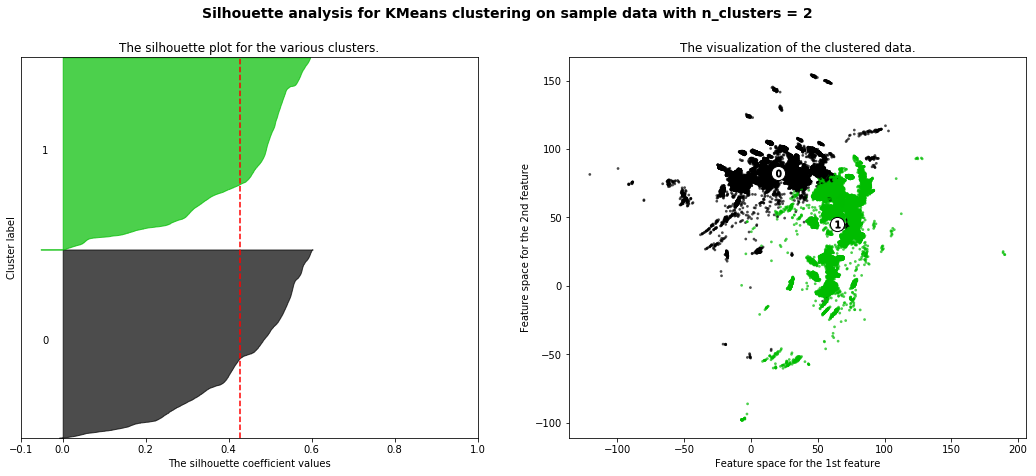

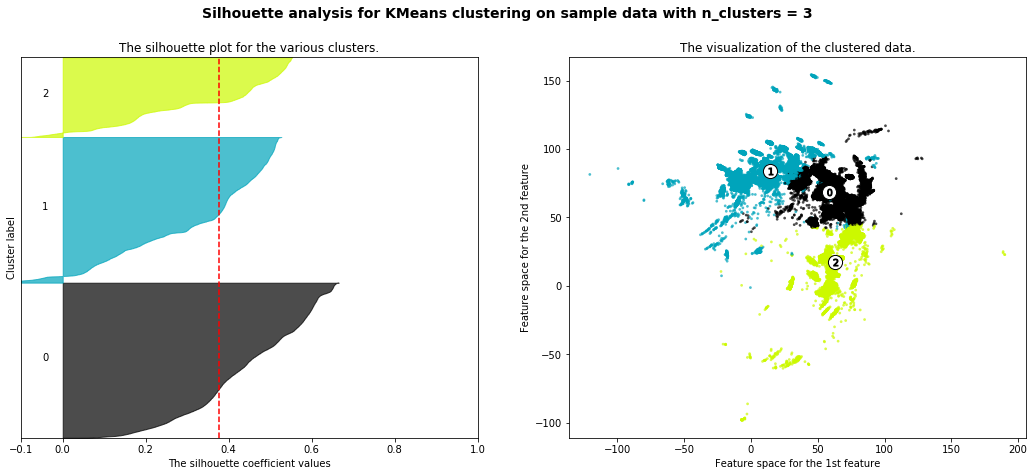

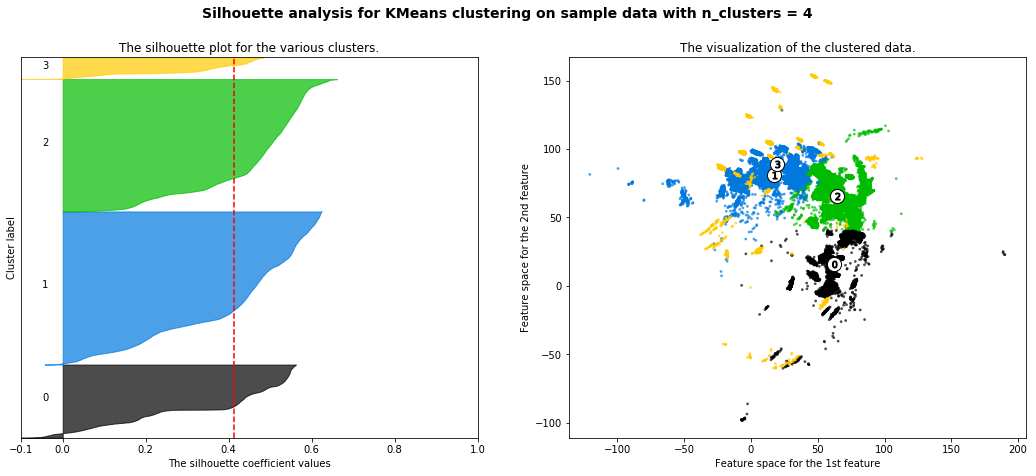

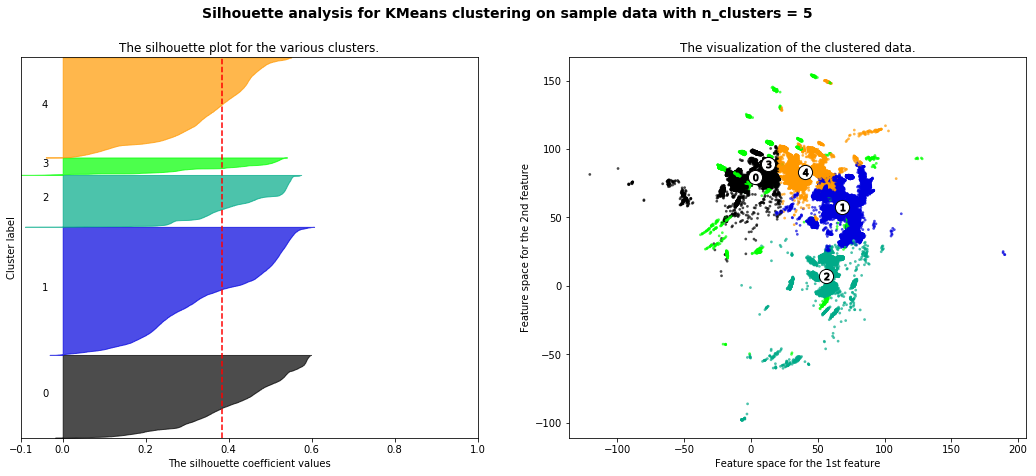

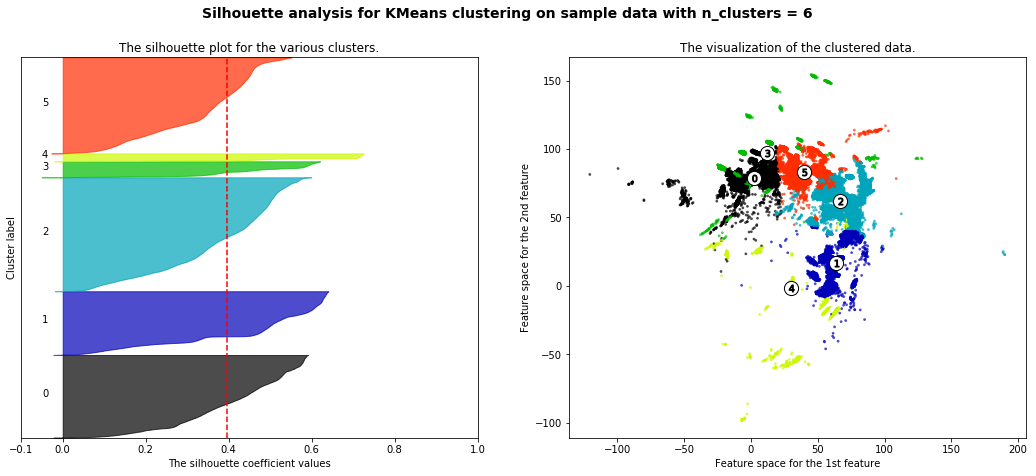

In [25]:
from __future__ import print_function

from sklearn.datasets import make_blobs
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score

import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np

print(__doc__)

y = df_adjacent_coords['Class']
X = (df_adjacent_coords
     .query('Class==\'fist\'')
     .loc[:,['X','Y','Z']]
     .values)

range_n_clusters = [2, 3, 4, 5, 6]

for n_clusters in range_n_clusters:
    # Create a subplot with 1 row and 2 columns
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(18, 7)

    # The 1st subplot is the silhouette plot
    # The silhouette coefficient can range from -1, 1 but in this example all
    # lie within [-0.1, 1]
    ax1.set_xlim([-0.1, 1])
    # The (n_clusters+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    ax1.set_ylim([0, len(X) + (n_clusters + 1) * 10])

    # Initialize the clusterer with n_clusters value and a random generator
    # seed of 10 for reproducibility.
    clusterer = KMeans(n_clusters=n_clusters, random_state=10)
    cluster_labels = clusterer.fit_predict(X)

    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters
    silhouette_avg = silhouette_score(X, cluster_labels)
    print("For n_clusters =", n_clusters,
          "The average silhouette_score is :", silhouette_avg)

    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(X, cluster_labels)

    y_lower = 10
    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = \
            sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / n_clusters)
        ax1.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

    # 2nd Plot showing the actual clusters formed
    colors = cm.nipy_spectral(cluster_labels.astype(float) / n_clusters)
    ax2.scatter(X[:, 0], X[:, 1], marker='.', s=30, lw=0, alpha=0.7,
                c=colors, edgecolor='k')

    # Labeling the clusters
    centers = clusterer.cluster_centers_
    # Draw white circles at cluster centers
    ax2.scatter(centers[:, 0], centers[:, 1], marker='o',
                c="white", alpha=1, s=200, edgecolor='k')

    for i, c in enumerate(centers):
        ax2.scatter(c[0], c[1], marker='$%d$' % i, alpha=1,
                    s=50, edgecolor='k')

    ax2.set_title("The visualization of the clustered data.")
    ax2.set_xlabel("Feature space for the 1st feature")
    ax2.set_ylabel("Feature space for the 2nd feature")

    plt.suptitle(("Silhouette analysis for KMeans clustering on sample data "
                  "with n_clusters = %d" % n_clusters),
                 fontsize=14, fontweight='bold')

plt.show()

The score is bounded between -1 for incorrect clustering and +1 for highly dense clustering. Scores around zero indicate overlapping clusters.
The score is higher when clusters are dense and well separated, which relates to a standard concept of a cluster.

## Modeling and Evaluation 1:
#### Requirements: Train and adjust parameters

In [40]:
### Gaussian Mixed Models
### This code is a modification of sklearn's website example and the example we ran in Unit 11.
import itertools

import numpy as np
from scipy import linalg
import matplotlib.pyplot as plt
import matplotlib as mpl

from sklearn import mixture

### y and X copied from Jose's clustering. I don't think that y is needed here. -Heber
### y = df_adjacent_coords['Class']. Line silenced by Heber
X = (df_adjacent_coords
     .query('Class==\'fist\'')
     .loc[:,['X','Y','Z']]
     .values)


lowest_bic = np.infty
bic = []
n_components_range = range(7, 32)
cv_types = ['spherical', 'diag', 'full']
for cv_type in cv_types:
    for n_components in n_components_range:
        # Fit a mixture of Gaussians with EM
        gmm = mixture.GaussianMixture(n_components=n_components, covariance_type=cv_type)
        gmm.fit(X)
        bic.append(gmm.bic(X))
        if bic[-1] < lowest_bic:
            lowest_bic = bic[-1]
            best_gmm = gmm
### This took about 10 minutes to run. -Heber

### PLOT THE BIC FROM THE GMM MODEL
### This code is a modification of sklearn's website example and the example we ran in Unit 11.

bic = np.array(bic)
color_iter = itertools.cycle(['k', 'r', 'b', 'g', 'c', 'm', 'y'])
clf = best_gmm
bars = []

plt.figure(figsize=(16,6))
spl = plt.subplot(1,1,1)
# Plot the BIC scores
for i, (cv_type, color) in enumerate(zip(cv_types, color_iter)):
    xpos = np.array(n_components_range) + .2 * (i - 2)
    bars.append(plt.bar(xpos, bic[i * len(n_components_range):
                                  (i + 1) * len(n_components_range)],
                        width=.3, color=color))
plt.xticks(n_components_range)
plt.ylim([bic.min() * 1.01 - .01 * bic.max(), bic.max() + 50000])
plt.title('BIC score per model')

xpos = np.min(n_components_range)-0.4 + np.mod(bic.argmin(), len(n_components_range)) +\
    .2 * np.floor(bic.argmin() / len(n_components_range))
plt.text(xpos, bic.min() * 0.97 + .03 * bic.max(), '*', fontsize=14)
spl.set_xlabel('Number of components')
spl.legend([b[0] for b in bars], cv_types)

plt.show()

#### This Gaussian Mixed Model is somewhat surprising in terms of the numbers of clusters. Originally the data were derived from 14 users, who each contributed data in 5 hand positions. That might indicate there could be as few as 5 or as many as 5x14=60 clusters. But in addition, each instance has a reading from at least 3 and as many as 7 markers, which might suggest that the number of ideal clusters could be as high as 7x60=420.  We would not expect so many clusters because of the conditions of the experiment, for several reasons. First, some of the markers do not change their location with 2 or more of the hand gestures. For example, a marker on the proximal metacarpal-metacarpal joint (first knuckle) would not change its theoretical position when the hand is held for a "Stop" position and a XXX position, nor would many of them change between a "Stop" position, a "One Finger Extended" position and a "2 Finger Extended Position". This could profoundly reduce the potentially large number of clusters. Second, it appears reasonable that for some of the gestures many of the users would have sufficiently similar size hands that markers would be closely clustered between such individuals. Overall, it is pretty impossible to predict in advance how many clusters should be present. Similarly, it is difficult to declare what data points, if any, are outliers.

## Modeling and Evaluation 1:
#### Requirements: Evaluate and Compare

## Modeling and Evaluation 3:
#### Requirements: Visualize Results

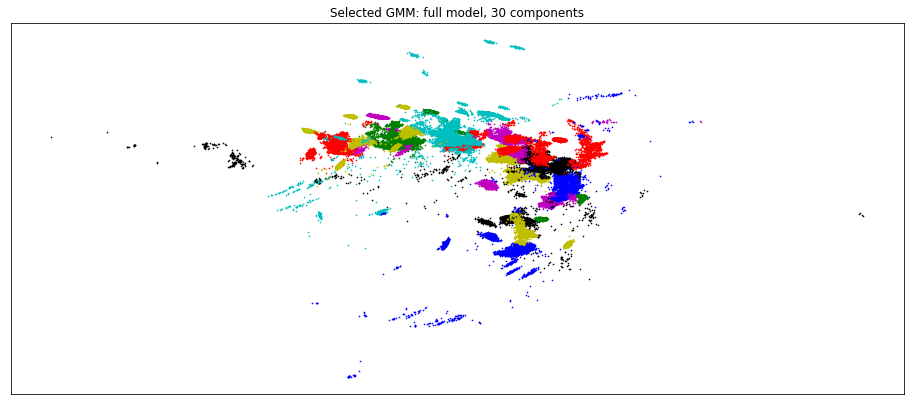

In [46]:
### This code is a modification of sklearn's website example
### Plot the winner

plt.figure(figsize=(16,6))
splot = plt.subplot(1, 1, 1)
Y_ = clf.predict(X)
for i, (mean, cov, color) in enumerate(zip(clf.means_, clf.covariances_,
                                           color_iter)):
    v, w = linalg.eigh(cov)
    if not np.any(Y_ == i):
        continue
    plt.scatter(X[Y_ == i, 0], X[Y_ == i, 1], .4, color=color)

    # Plot an ellipse to show the Gaussian component
    # angle = np.arctan2(w[0][1], w[0][0])
    # angle = 180. * angle / np.pi  # convert to degrees
    # v = 2. * np.sqrt(2.) * np.sqrt(v)
    # ell = mpl.patches.Ellipse(mean, v[0], v[1], 180. + angle, color=color)
    # ell.set_clip_box(splot.bbox)
    # ell.set_alpha(.5)
    # splot.add_artist(ell)

plt.xticks(())
plt.yticks(())
plt.title('Selected GMM: full model, 30 components')
plt.subplots_adjust(hspace=.35, bottom=.02)
plt.show()

## Modeling and Evaluation 4:
#### Requirements: Summarize the Ramifications

## Deployment:
#### Requirements: Be critical of your performance and tell the reader how you current model might be usable by other parties. Did you achieve your goals? If not, can you reign in the utility of your modeling?
##### How useful is your model for interested parties (i.e., the companies or organizations that might want to use it)?
##### How would your deploy your model for interested parties?
##### What other data should be collected? 
#####  How often would the model need to be updated, etc.?

### Exceptional Work:
#### Requirements: You have free reign to provide additional analyses or combine analyses.

### (FROM HERE ONWARDS, THESE ARE SECTIONS WE MIGHT USE AS SUBSECTIONS WITHIN THE MAIN SECTIONS ABOVE.
##### -Heber)

## Evaluation:

## Data Preparation:

#### Data Meaning Type:

## Data Quality:

### Missing Values:

### Outliers:

## Data Visualization and Visual Analysis:

## Summary Statistics and Commentary:

### Main Observations:

# Heber trying some new procedures for clustering. These next cells are all temporary.

In [2]:
pip install pyclustering


The following command must be run outside of the IPython shell:

    $ pip install pyclustering

The Python package manager (pip) can only be used from outside of IPython.
Please reissue the `pip` command in a separate terminal or command prompt.

See the Python documentation for more information on how to install packages:

    https://docs.python.org/3/installing/


In [13]:
import chameleon as ch
import numpy as np
import networkx as nx
from tqdm import tqdm
#import visualization
#import metis


def euclidean_distance(a, b):
    return np.linalg.norm(np.array(a) - np.array(b))


def knn_graph(df, k, verbose=False):
    points = [p[1:] for p in df.itertuples()]
    g = nx.Graph()
    for i in range(0, len(points)):
        g.add_node(i)
    if verbose:
        print("Building kNN graph (k = %d)..." % (k))
    iterpoints = tqdm(enumerate(points), total=len(
        points)) if verbose else enumerate(points)
    for i, p in iterpoints:
        distances = list(map(lambda x: euclidean_distance(p, x), points))
        closests = np.argsort(distances)[1:k+1]  # second through kth closest
        # print(distances[0])
        for c in closests:
            g.add_edge(i, c, weight=1.0 / distances[c], similarity=int(
                1.0 / distances[c] * 1e4))
        g.node[i]['pos'] = p
    g.graph['edge_weight_attr'] = 'similarity'
    return g


def part_graph(graph, k, df=None):
    edgecuts, parts = metis.part_graph(
        graph, 2, objtype='cut', ufactor=250)
    # print(edgecuts)
    for i, p in enumerate(graph.nodes()):
        graph.node[p]['cluster'] = parts[i]
    if df is not None:
        df['cluster'] = nx.get_node_attributes(graph, 'cluster').values()
    return graph


def pre_part_graph(graph, k, df=None, verbose=False):
    if verbose:
        print("Begin clustering...")
    clusters = 0
    for i, p in enumerate(graph.nodes()):
        graph.node[p]['cluster'] = 0
    cnts = {}
    cnts[0] = len(graph.nodes())

    while clusters < k - 1:
        maxc = -1
        maxcnt = 0
        for key, val in cnts.items():
            if val > maxcnt:
                maxcnt = val
                maxc = key
        s_nodes = [n for n in graph.node if graph.node[n]['cluster'] == maxc]
        s_graph = graph.subgraph(s_nodes)
        edgecuts, parts = metis.part_graph(
            s_graph, 2, objtype='cut', ufactor=250)
        new_part_cnt = 0
        for i, p in enumerate(s_graph.nodes()):
            if parts[i] == 1:
                graph.node[p]['cluster'] = clusters + 1
                new_part_cnt = new_part_cnt + 1
        cnts[maxc] = cnts[maxc] - new_part_cnt
        cnts[clusters + 1] = new_part_cnt
        clusters = clusters + 1

    edgecuts, parts = metis.part_graph(graph, k)
    if df is not None:
        df['cluster'] = nx.get_node_attributes(graph, 'cluster').values()
    return graph


def get_cluster(graph, clusters):
    nodes = [n for n in graph.node if graph.node[n]['cluster'] in clusters]
    return nodes


def connecting_edges(partitions, graph):
    cut_set = []
    for a in partitions[0]:
        for b in partitions[1]:
            if a in graph:
                if b in graph[a]:
                    cut_set.append((a, b))
    return cut_set


def min_cut_bisector(graph):
    graph = graph.copy()
    graph = part_graph(graph, 2)
    partitions = get_cluster(graph, [0]), get_cluster(graph, [1])
    return connecting_edges(partitions, graph)


def get_weights(graph, edges):
    return [graph[edge[0]][edge[1]]['weight'] for edge in edges]


def bisection_weights(graph, cluster):
    cluster = graph.subgraph(cluster)
    edges = min_cut_bisector(cluster)
    weights = get_weights(cluster, edges)
return weights

NameError: name 'weights' is not defined

In [14]:
import pandas as pd

from visualization import *
from chameleon import *

if __name__ == "__main__":
    # get a set of data points
    df = df#pd.read_csv('./datasets/Aggregation.csv', sep=' ',
#                     header=None)

    # returns a pandas.dataframe of cluster
    res = cluster(df, 7, knn=20, m=40, alpha=2.0, plot=False)

    # draw a 2-D scatter plot with cluster
plot2d_data(res)

ModuleNotFoundError: No module named 'visualization'